In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Problem
One problem in route flow inference from cellular network data is how to match a
user's cell traces to a cellpath corresponding to a route. The latter cellpath
is generated by finding all cells passing through a route, while the former
cellpath is collected from a user's phone connection to cell towers.

A user's cellpath can be noisy and even discontinuous, yet we need to establish
a means of finding the best match between this cellpath and all the other
cellpaths defined by the multiple routes in order to generate the $f$ vector in
$Ux=f$.

One way to determine how close two cellpaths are to each other is to view them
as sets of cells, and use the Jacquard distance to measure similarity between
sets. For sets $A$ and $B$, the Jacquard distance is

$$J(A, B) \equiv \frac{|A \cap B|}{|A \cup B|},$$

the ratio between their intersection and their union. Its value ranges from 0 to
1, corresponding to disjoint sets and two equal sets respectively. Besides being
normalized and easy to compute, there is another motivation for choosing this
metric. There are around the order of 1 million of both types of cellpaths, to
match them using the naive $O(n^2)$ algorithm would be way too slow. We need a
sublinear-time method of performing each match. 

## Hashing Procedure
Denote the universe (set containing all cells) as $U$. Suppose we have a hash
function $h^i$ with domain $U$. We define:

$$h^i_\text{min}(A) \equiv \min \{ h^i(x) \mid x \in A \}$$

The following result holds if $h^i$ is a random permutation on $U$:

$$\Pr[h^i_\text{min}(A) = h^i_\text{min}(B)] = J(A, B)$$

We want to use this fact to create a _locality-sensitive hash_, a hash where two
sets with high Jacquard distance have a high probability of being hashed into
the same bucket. We want to insert the collection of all possible cellpaths into
a easy-lookup datastructure. To do this, we first choose $kb$ random hash
functions $h^1$ to $h^{kb}$ and create $k$ hash tables $H_1$ to $H_k$.

For each set $A_i$ and hash table $H_j$, we add $A_i$ into bucket
$H_j\left[\overline{h^{(j-1)b+1}_\text{min}(A_i) \cdots
h^{jb}_\text{min}(A_i)}\right]$. The overline indicates concatenation of the values
from hash functions. Each bucket can contain more than one set.

To lookup a set $B$, we first obtain a candidate collection of sets $C$ as a
union of all buckets corresponding to $B$ in each hash table $H_j$:

$$ C = \bigcup_{j=1}^k H_j\left[\overline{h^{(j-1)b+1}_\text{min}(A_i) \cdots
h^{jb}_\text{min}(A_i)}\right] $$

Then we find the best match out of these candidates:

$$ \max_i(J(C_i, B)) $$

## Analysis
Here we compute the probability of a pair of sets with Jacquard distance $p$
ending up in the same bucket:

$$f(p) = 1-(1-p^k)^b$$

We also compute the probability threshold, which is the inflection point in this
function. It is given by:

$$\frac{d^2f}{dp^2} = 0$$
$$\left( \frac{(b-1)k}{k-1} + 1\right)^{-1/k} \approx b^{-1/k}$$


In [2]:
f = lambda p, b, k: 1 - (1 - p**k)**b
threshold = lambda b, k: ((b-1)*k/float(k-1)+1)**(-1.0/k)

First we create some helper plotting functions.

In [3]:
def plot(b, k):
    x = np.linspace(0, 1, 100)
    y = f(x, b, k)
    plt.plot(x, y, label='b={},k={}'.format(b, k))
    plt.axvline(x=threshold(b, k))

def plot_series(seq):
    plt.figure(figsize=(10,5))
    for b, k in seq:
        plot(b, k) 
    ax = plt.gca()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Jacquard distance between two sets')
    plt.ylabel('Probability of one set chosen as candidate for the other')

We can investigate how $b$ and $k$ affect the threshold function. We want to get
the best curve with the lowest $b*k$ value to reduce computation time. We fix
$b=5$ and vary $k$. Notice that $k$ mainly changes the false positive rate.

In [4]:
plot_series([(5, k) for k in range(4, 28, 4)])

Now we fix $k=5$ and vary $b$. Notice that $b$ mainly changes the false negative rate.

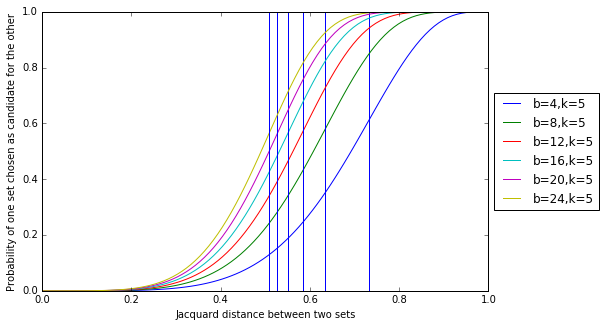

In [5]:
plot_series([(b, 5) for b in range(4, 28, 4)])

Now we fix $b*k=24$ and graph the respective thresholds.

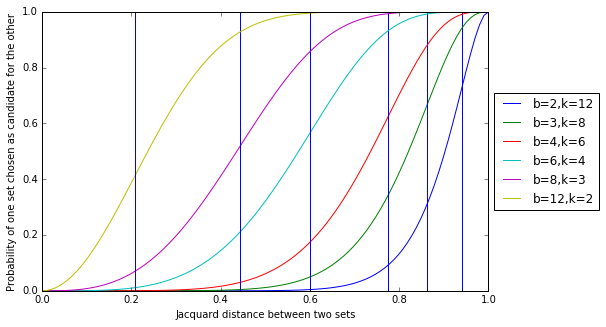

In [6]:
plot_series([(2, 12), (3, 8), (4, 6), (6, 4), (8, 3), (12, 2)])

If $b \times k = c$, then we can plot the threshold value as a function of $b$:

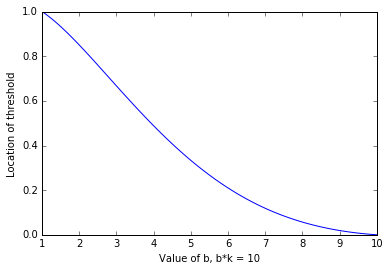

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


In [7]:
c = 10
b = np.linspace(1, c, 100)
k = c / b
plt.plot(b, [threshold(bi, ki) for bi, ki in zip(b, k)])
plt.ylabel('Location of threshold')
plt.xlabel('Value of b, b*k = 10')
plt.show()

We define $a(b, k)$ to be the slope of the transfer function at the threshold,
as a function of $b$ and $k$:

$$a(b, k) \approx k b^{1/k} (1 - 1/b)^{b-1} $$

In [9]:
c = 10
b = np.linspace(1, c, 100)
k = c / b
a = lambda b, k: k * b**(1/float(k)) * (1 - 1/float(b))**(b-1)
df = lambda p, b, k: b * (1-p**k)**(b-1) * k * p**(k-1)

print('b=7, k=5, approx: {}, exact:{} '\
  .format(a(7, 5), max([df(p, 7, 5) for p in np.linspace(0, 1, 500)])))

b=7, k=5, approx: 2.926232803821344, exact:2.981151408734262 


## Experimental Results
We graph the threshold function chosen and used in the AT&T experiments, where
$b=7$ and $k=5$.

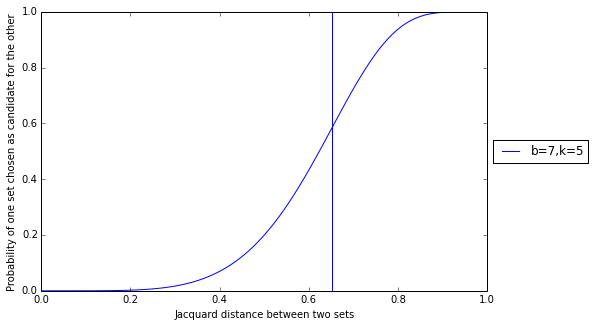

Threshold: 0.651802789631


In [32]:
plot_series([(7, 5)])
print 'Threshold: ' + str(threshold(7, 5))

Now we import the actual matches of SSTEM cellpaths and plot a histogram of the
match percentages:

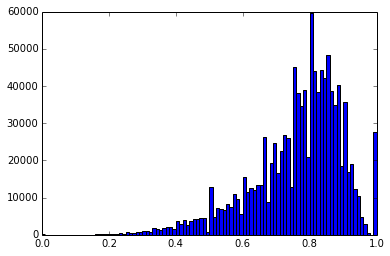

In [33]:
matched = json.load(open('f_patched_cellpath.json'))
plt.hist([m[1] for m in matched if m], bins=100)
plt.show()

Here we compare ~600 matches between brute-force and LSH:

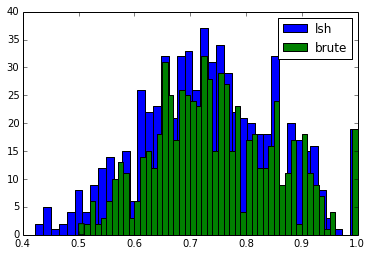

In [34]:
compare = json.load(open('compare.json'))
lsh = [c['lsh_d'] for c in compare]
brute = [c['brute_d'] for c in compare]
plt.hist(lsh, label='lsh', bins=50)
plt.hist(brute, label='brute', bins=50)
plt.xlim(0.4, 1.0)
plt.legend()
plt.show()

Here we look at the accuracy of lsh versus brute force (1.00):

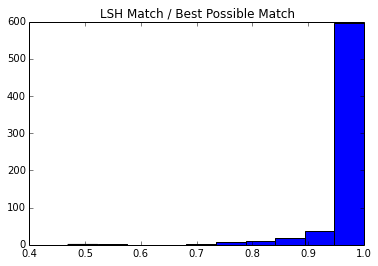

In [35]:
plt.hist([l/float(b) for l, b in zip(lsh, brute)], bins=10)
plt.title('LSH Match / Best Possible Match')
plt.show()